In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')


## Read in data

In [2]:
## Load data rather than re-create (it takes a long time to read it all in) 
saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/ens_byLeadDay/'

hmg_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HMG_day2_30min_pert00.p" , "rb") )
htg_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HTG_day2_30min_pert00.p" , "rb") )

hmgCLM_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HMGclm_day2_30min_pert00.p" , "rb") )
htgCLM_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HTGclm_day2_30min_pert00.p" , "rb") )
print('Done reading in HMG and HTG') 

## -------------------------------------------------------------------------
## For the HTG*10 case, files are split up by year and need to be merged 
yearStr = ['2015','2016','2017','2018']

for iYr in range(len(yearStr)): 
    
    htg_day2_upsample10_temp     = pickle.load( open( saveDir+"realSfc_HTGmult10_"   +yearStr[iYr]+"day2_30min_pert00.p" , "rb") )
    htgCLM_day2_upsample10_temp  = pickle.load( open( saveDir+"realSfc_HTGclmMult10_"+yearStr[iYr]+"day2_30min_pert00.p" , "rb") )
    # print(len(htg_day2_upsample10_temp.time.values))
    
    if iYr==0:
        ## 2015 CLM: had saved all variables, not just some
        keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA','USTAR','WSTAR','ZETA']
        htgCLM_day2_upsample10_temp = htgCLM_day2_upsample10_temp[keepVars_CLM]
 
        htg_day2_upsample10    = htg_day2_upsample10_temp
        htgCLM_day2_upsample10 = htgCLM_day2_upsample10_temp
      
    else: 
        htg_day2_upsample10 = xr.concat([htg_day2_upsample10,    htg_day2_upsample10_temp],  dim='time')
        htgCLM_day2_upsample10 = xr.concat([htgCLM_day2_upsample10,    htgCLM_day2_upsample10_temp],  dim='time')
print('Read in ens00, HTG*10')

## -------------------------------------------------------------------------
## For the HTG*100 case, files are split up by year and need to be merged 

yearStr = ['2015','2016','2017','2018']

for iYr in range(len(yearStr)): 
    
    htg_day2_upsample100_temp     = pickle.load( open( saveDir+"realSfc_HTGmult100_"   +yearStr[iYr]+"day2_30min_pert00.p" , "rb") )
    htgCLM_day2_upsample100_temp  = pickle.load( open( saveDir+"realSfc_HTGclmMult100_"+yearStr[iYr]+"day2_30min_pert00.p" , "rb") )
    # print(len(htg_day2_upsample100_temp.time.values))
     
    if iYr==0:
        ## 2015 CLM: had saved all variables, not just some
        keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA','USTAR','WSTAR','ZETA']
        htgCLM_day2_upsample100_temp = htgCLM_day2_upsample100_temp[keepVars_CLM]

        htg_day2_upsample100    = htg_day2_upsample100_temp
        htgCLM_day2_upsample100 = htgCLM_day2_upsample100_temp
    else: 
        htg_day2_upsample100 = xr.concat([htg_day2_upsample100,    htg_day2_upsample100_temp],  dim='time')
        htgCLM_day2_upsample100 = xr.concat([htgCLM_day2_upsample100,    htgCLM_day2_upsample100_temp],  dim='time')
print('Read in ens00, HTG*100')



Done reading in HMG and HTG
Read in ens00, HTG*10
Read in ens00, HTG*100


In [3]:
## Combine things to make it all a bit easier to handle... 

hmg_day2_upsample01 = hmg_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HMG'})
htg_day2_upsample01 = htg_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HTG'})
htg_day2_upsample100 = htg_day2_upsample100.dropna(dim='time',how='all').assign_coords({"case": 'HTG*100'})
htg_day2_upsample10 = htg_day2_upsample10.dropna(dim='time',how='all').assign_coords({"case": 'HTG*10'})
day2_upsample       = xr.concat([hmg_day2_upsample01, htg_day2_upsample01, htg_day2_upsample10, htg_day2_upsample100], "case")

hmgCLM_day2_upsample01 = hmgCLM_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HMG'})
htgCLM_day2_upsample01 = htgCLM_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HTG'})
htgCLM_day2_upsample100 = htgCLM_day2_upsample100.dropna(dim='time',how='all').assign_coords({"case": 'HTG*100'})
htgCLM_day2_upsample10 = htgCLM_day2_upsample10.dropna(dim='time',how='all').assign_coords({"case": 'HTG*10'})
day2_upsampleCLM       = xr.concat([hmgCLM_day2_upsample01, htgCLM_day2_upsample01, htgCLM_day2_upsample10, htgCLM_day2_upsample100], "case")


In [4]:
# Add month_day index to arrays
month_day_day2                     = pd.MultiIndex.from_arrays([day2_upsample['time.year'].values,
                                                                day2_upsample['time.month'].values, 
                                                                day2_upsample['time.day'].values])
day2_upsample.coords['year_month_day']     = ('time', month_day_day2)
day2_upsampleCLM.coords['year_month_day']  = ('time', month_day_day2)


## What's the *mean* response?

### Diurnal cycle?

In [9]:
day2_hrMeans = day2_upsample.groupby("time.hour").mean(dim="time")
day2_hrStd   = day2_upsample.groupby("time.hour").std(dim="time")

# Get number of obs going into each bin above (for std err) 
nTimes_means = np.full([24], np.nan)
for iHr in range(24): 
    nTimes_means[iHr]    = len(np.where(day2_upsample["time.hour"]==iHr)[0])
    
day2_hrMeans['SampleCount'] = (('hour'), nTimes_means)


Text(0.5, 0, 'Local Hour')

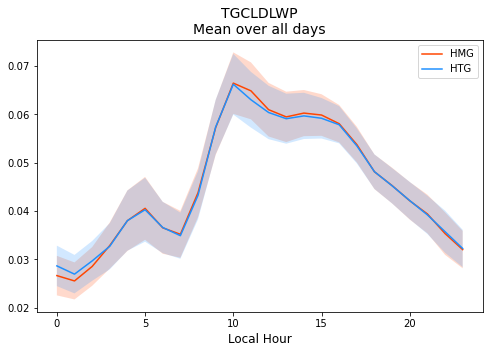

In [11]:
varSelPlot = 'TGCLDLWP' 
levSel     = None

fig,axs = plt.subplots(1,1, figsize=(8,5))

CIlevel = 1.645   ## 90% CI
    
colorList=['orangered','dodgerblue','forestgreen','blueviolet']

for iCase in range(len(day2_hrMeans.case.values)): 
    
    if ((day2_hrMeans.case.values[iCase]=='HMG') | (day2_hrMeans.case.values[iCase]=='HTG')):
        caseName = day2_hrMeans.case.values[iCase]
        axs.plot(np.arange(24), np.squeeze(day2_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

        axs.fill_between(np.arange(24), 
                         np.squeeze(day2_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2_hrMeans['SampleCount'].values),
                         np.squeeze(day2_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2_hrMeans['SampleCount'].values),
                         alpha = 0.2, facecolor=colorList[iCase])

axs.legend()
axs.set_title(varSelPlot+'\nMean over all days', fontsize=14)
axs.set_xlabel('Local Hour', fontsize=12)


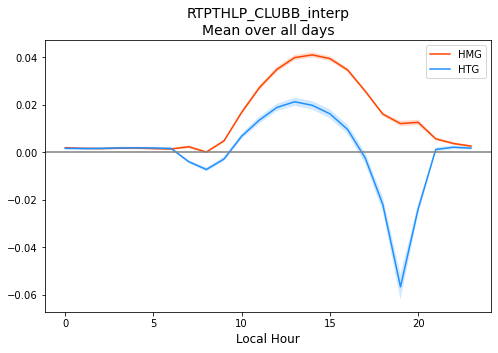

In [16]:
varSelPlot = 'RTPTHLP_CLUBB_interp' 
levSel     = -1

fig,axs = plt.subplots(1,1, figsize=(8,5))

CIlevel = 1.645   ## 90% CI
    
colorList=['orangered','dodgerblue','forestgreen','blueviolet']

for iCase in range(len(day2_hrMeans.case.values)): 
    
    if ((day2_hrMeans.case.values[iCase]=='HMG') | (day2_hrMeans.case.values[iCase]=='HTG')):
        caseName = day2_hrMeans.case.values[iCase]
        axs.plot(np.arange(24), np.squeeze(day2_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

        axs.fill_between(np.arange(24), 
                         np.squeeze(day2_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2_hrMeans['SampleCount'].values),
                         np.squeeze(day2_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2_hrMeans['SampleCount'].values),
                         alpha = 0.2, facecolor=colorList[iCase])

axs.legend()
axs.set_title(varSelPlot+'\nMean over all days', fontsize=14)
axs.set_xlabel('Local Hour', fontsize=12)
axs.axhline(0,color='grey')


In [5]:
# Select only the hours 06-18 LT
iHours        = np.where( (day2_upsample['time.hour']>=6) & (day2_upsample['time.hour']<=18) )[0]
day2_hourSel  = day2_upsample.isel(time=iHours).groupby('year_month_day').mean(dim='time')

day2_hourSel

<xarray.Dataset>
Dimensions:                 (case: 4, ilev: 65, lat: 1, lat,: 1, lev: 64, levInterp: 78, lon: 1, year_month_day: 356)
Coordinates:
  * lat                     (lat) float64 36.61
  * lon                     (lon) float64 262.5
  * lev                     (lev) float64 2.949 4.338 6.313 ... 988.8 996.3
  * ilev                    (ilev) float64 2.255 3.643 5.032 ... 992.6 1e+03
    pertlim                 int64 0
  * levInterp               (levInterp) float64 200.0 210.0 ... 960.0 970.0
  * case                    (case) object 'HMG' 'HTG' 'HTG*10' 'HTG*100'
  * year_month_day          (year_month_day) MultiIndex
  - year_month_day_level_0  (year_month_day) int64 2015 2015 2015 ... 2018 2018
  - year_month_day_level_1  (year_month_day) int64 6 6 6 6 6 6 6 ... 8 8 8 8 8 8
  - year_month_day_level_2  (year_month_day) int64 2 3 4 5 6 ... 25 26 27 28 29
Dimensions without coordinates: lat,
Data variables:
    ntrk                    (year_month_day, case) float64 1.0 1.0 ... 1.0 1.0
    ntrn                    (year_month_day, case) float64 1.0 1.0 ... 1.0 1.0
    ntrm                    (year_month_day, case) float64 1.0 1.0 ... 1.0 1.0
    gw                      (year_month_day, case, lat) float64 2.0 2.0 ... 2.0
    hyam                    (year_month_day, case, lev) float64 0.002949 ... 0.0
    hybm                    (year_month_day, case, lev) float64 0.0 ... 0.9963
    P0                      (year_month_day, case) float64 1e+05 1e+05 ... 1e+05
    hyai                    (year_month_day, case, ilev) float64 0.002255 ......
    hybi                    (year_month_day, case, ilev) float64 0.0 0.0 ... 1.0
    date                    (year_month_day, case) float64 2.015e+07 ... 2.01...
    datesec                 (year_month_day, case) float64 6.266e+04 ... 6.26...
    ndbase                  (year_month_day, case) float64 0.0 0.0 ... 0.0 0.0
    nsbase                  (year_month_day, case) float64 0.0 0.0 ... 0.0 0.0
    nbdate                  (year_month_day, case) float64 2.015e+07 ... 2.01...
    nbsec                   (year_month_day, case) float64 1.806e+04 ... 1.80...
    mdt                     (year_month_day, case) float64 300.0 300.0 ... 300.0
    ndcur                   (year_month_day, case) float64 1.0 1.0 ... 1.0 1.0
    nscur                   (year_month_day, case) float64 4.515e+04 ... 4.51...
    co2vmr                  (year_month_day, case) float64 0.0003728 ... 0.00...
    ch4vmr                  (year_month_day, case) float64 1.841e-06 ... 1.83...
    n2ovmr                  (year_month_day, case) float64 3.16e-07 ... 3.159...
    f11vmr                  (year_month_day, case) float64 7.088e-10 ... 7.07...
    f12vmr                  (year_month_day, case) float64 5.414e-10 ... 5.41...
    sol_tsi                 (year_month_day, case) float64 -1.0 -1.0 ... -1.0
    nsteph                  (year_month_day, case) float64 438.5 438.5 ... 438.5
    CAPE                    (year_month_day, case, lat, lon) float32 92.79 .....
    CDNUMC                  (year_month_day, case, lat, lon) float32 26.21 .....
    CLDBOT                  (year_month_day, case, lat, lon) float32 28.87 .....
    CLDLOW                  (year_month_day, case, lat, lon) float32 0.05253 ...
    CLDMED                  (year_month_day, case, lat, lon) float32 0.07026 ...
    CLDTOP                  (year_month_day, case, lat, lon) float32 52.34 .....
    CLDTOT                  (year_month_day, case, lat, lon) float32 0.5194 ....
    CLOUDCOVER_CLUBB        (year_month_day, case, ilev, lat, lon) float32 0....
    CLOUDFRAC_CLUBB         (year_month_day, case, lev, lat, lon) float32 0.0...
    GCLDLWP                 (year_month_day, case, lev, lat, lon) float32 0.0...
    LHFLX                   (year_month_day, case, lat, lon) float32 128.6 .....
    OMEGA                   (year_month_day, case, lev, lat, lon) float32 0.0...
    PBLH                    (year_month_day, case, lat, lon) float32 1.167e+0...
    PHIS

[None, None, None, None]

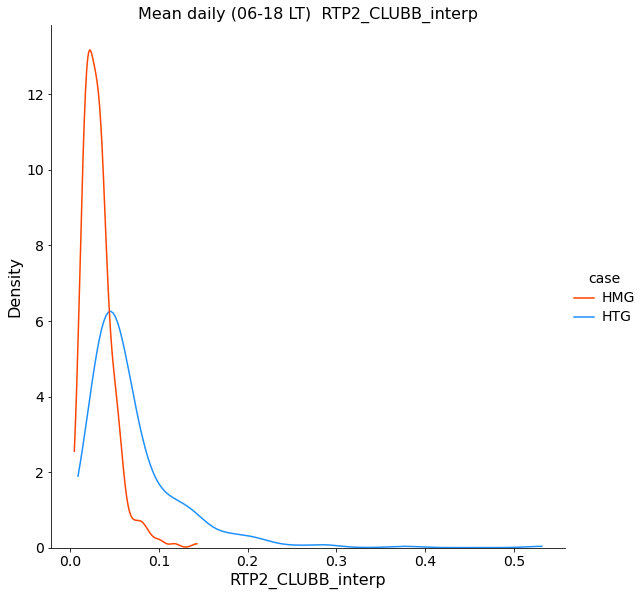

In [9]:
# Define dataframe
distVar = 'RTP2_CLUBB_interp'
levsel  = -1

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_hourSel.sel(case='HMG').isel(levInterp=levsel)[distVar].values),    'case': 'HMG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_hourSel.sel(case='HTG').isel(levInterp=levsel)[distVar].values), 'case': 'HTG'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("Mean daily (06-18 LT)  "+distVar, fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)


### Vertically?

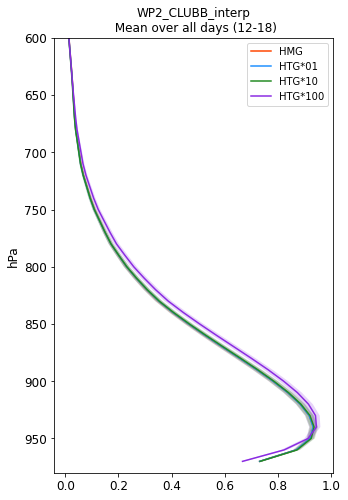

In [14]:
plotVar   = 'WP2_CLUBB_interp' 
levString = 'levInterp' 


## Step 1: Which hours to average over? 
startHr = 12
endHr   = 18

iHours = np.where( (day2_upsample['time.hour'].values>=startHr) & (day2_upsample['time.hour'].values<=endHr) )[0]

## Step 2: Get a mean over all days during those hours only 
# day2_hoursSel = day2_upsample.isel(time=iHours)
# day2_meanDailyPeriod = day2_hoursSel.groupby('year_month_day').mean(dim='time')
# day2_meanProfiles    = day2_meanDailyPeriod.mean(dim='year_month_day')

day2_meanProfiles = day2_upsample.isel(time=iHours).mean(dim='time')
day2_stdProfiles  = day2_upsample.isel(time=iHours).std(dim='time')


## Step 3: Plot 

fig,axs = plt.subplots(1,1, figsize=(5,8))
CIlevel = 1.645   ## 90% CI
colorList=['orangered','dodgerblue','forestgreen','blueviolet']


for iCase in range(len(day2_meanProfiles.case.values)): 
    caseName = day2_meanProfiles.case.values[iCase]
    
    valuesCase = np.squeeze(day2_meanProfiles.sel(case=caseName)[plotVar].values)

    axs.plot(valuesCase, day2_meanProfiles[levString].values,
             color=colorList[iCase],label=caseName)
    axs.fill_betweenx(day2_meanProfiles[levString].values, 
                      valuesCase-CIlevel*(np.squeeze(day2_stdProfiles.sel(case=caseName)[plotVar].values)/np.sqrt(len(iHours))),
                      valuesCase+CIlevel*(np.squeeze(day2_stdProfiles.sel(case=caseName)[plotVar].values)/np.sqrt(len(iHours))),
                      alpha = 0.2, facecolor=colorList[iCase])


axs.legend()
axs.invert_yaxis()
axs.set_ylim([980,600])
axs.set_title(plotVar+'\n Mean over all days ('+str(startHr)+'-'+str(endHr)+')')

if plotVar.endswith('_interp'):
    axs.set_ylabel('hPa', fontsize=12)
else:
    axs.set_ylabel('hPa (model hybrid coord)', fontsize=12)

axs.tick_params(axis='both', labelsize= 12)

# axs.set_xlim([285,305])


In [47]:
day2_hrMeans

<xarray.Dataset>
Dimensions:                 (case: 4, hour: 24, ilev: 65, lat: 1, lat,: 1, lev: 64, levInterp: 78, lon: 1)
Coordinates:
  * lat                     (lat) float64 36.61
  * lon                     (lon) float64 262.5
  * lev                     (lev) float64 2.949 4.338 6.313 ... 988.8 996.3
  * ilev                    (ilev) float64 2.255 3.643 5.032 ... 992.6 1e+03
    pertlim                 int64 0
  * levInterp               (levInterp) float64 200.0 210.0 ... 960.0 970.0
  * case                    (case) object 'HMG' 'HTG*01' 'HTG*10' 'HTG*100'
  * hour                    (hour) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
Dimensions without coordinates: lat,
Data variables:
    ntrk                    (hour, case) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ntrn                    (hour, case) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ntrm                    (hour, case) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    gw                      (hour, case, lat) float64 2.0 2.0 2.0 ... 2.0 2.0
    hyam                    (hour, case, lev) float64 0.002949 0.004338 ... 0.0
    hybm                    (hour, case, lev) float64 0.0 0.0 ... 0.9888 0.9963
    P0                      (hour, case) float64 1e+05 1e+05 ... 1e+05 1e+05
    hyai                    (hour, case, ilev) float64 0.002255 0.003643 ... 0.0
    hybi                    (hour, case, ilev) float64 0.0 0.0 ... 0.9926 1.0
    date                    (hour, case) float64 2.017e+07 ... 2.017e+07
    datesec                 (hour, case) float64 2.001e+04 ... 1.641e+04
    ndbase                  (hour, case) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nsbase                  (hour, case) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nbdate                  (hour, case) float64 2.017e+07 ... 2.017e+07
    nbsec                   (hour, case) float64 1.806e+04 ... 1.806e+04
    mdt                     (hour, case) float64 300.0 300.0 ... 300.0 300.0
    ndcur                   (hour, case) float64 1.0 1.0 1.0 ... 1.083 1.083
    nscur                   (hour, case) float64 1.95e+03 1.95e+03 ... 7.755e+04
    co2vmr                  (hour, case) float64 0.0003689 ... 0.0003688
    ch4vmr                  (hour, case) float64 1.835e-06 ... 1.835e-06
    n2ovmr                  (hour, case) float64 3.159e-07 ... 3.159e-07
    f11vmr                  (hour, case) float64 7.075e-10 ... 7.075e-10
    f12vmr                  (hour, case) float64 5.413e-10 ... 5.413e-10
    sol_tsi                 (hour, case) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    nsteph                  (hour, case) float64 294.5 294.5 ... 570.5 570.5
    CAPE                    (hour, case, lat, lon) float32 111.9 113.2 ... 114.9
    CDNUMC                  (hour, case, lat, lon) float32 3.641e+09 ... 4.72...
    CLDBOT                  (hour, case, lat, lon) float32 19.77 20.08 ... 20.64
    CLDLOW                  (hour, case, lat, lon) float32 0.06648 ... 0.07057
    CLDMED                  (hour, case, lat, lon) float32 0.1281 ... 0.1832
    CLDTOP                  (hour, case, lat, lon) float32 57.85 57.34 ... 55.8
    CLDTOT                  (hour, case, lat, lon) float32 0.6484 ... 0.7112
    CLOUDCOVER_CLUBB        (hour, case, ilev, lat, lon) float32 0.0 ... 0.00...
    CLOUDFRAC_CLUBB         (hour, case, lev, lat, lon) float32 0.0 ... 0.005647
    GCLDLWP                 (hour, case, lev, lat, lon) float32 0.0 ... 0.000136
    LHFLX                   (hour, case, lat, lon) float32 15.53 15.54 ... 16.67
    OMEGA                   (hour, case, lev, lat, lon) float32 0.0 ... -0.00...
    PBLH                    (hour, case, lat, lon) float32 291.5 284.2 ... 209.2
    PHIS                    (hour, case, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    PRECC                   (hour, case, lat, lon) float32 1.19e-08 ... 1.751...
    PRECT                   (hour, case, lat, lon) float32 2.539e-08 ... 2.80...
    PRECZ                   (hour, case, lat, lon) float32 1.19e-08 ... 1.751...
   

Text(0.5, 1.0, '\nHTG*100-HMG (all days)')

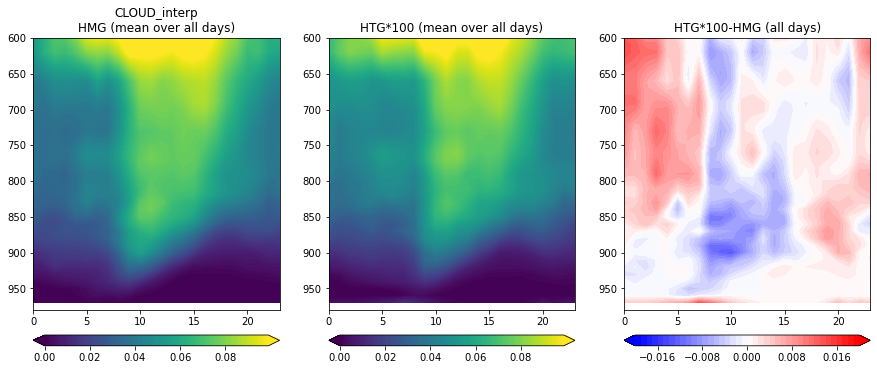

In [114]:
# plotVar   = 'Q_interp' 
# levsRaw   = np.arange(0,0.015, 0.0005)
# levsDiff  = np.arange(-0.0015, 0.0016, 0.0001)

# plotVar   = 'T_interp' 
# levsRaw   = np.arange(275,305,1)
# levsDiff  = np.arange(-1.3, 1.31, 0.01)

plotVar   = 'CLOUD_interp' 
levsRaw   = np.arange(0,0.1,0.001)
levsDiff  = np.arange(-0.02,0.021, 0.001)

# plotVar   = 'THLP2_CLUBB_interp' 
# levsRaw   = np.arange(0.01,1.5,0.005)
# levsDiff  = np.arange(-1.0, 1.01, 0.01)

# plotVar   = 'RTP2_CLUBB_interp' 
# levsRaw   = np.arange(0.02,0.6,0.005)
# levsDiff  = np.arange(-0.8,0.81, 0.01)

# plotVar   = 'RTPTHLP_CLUBB_interp' 
# levsRaw   = np.arange(-0.25,0.05,0.005)
# levsDiff  = np.arange(-0.3,0.31, 0.01)

# plotVar   = 'WP2_CLUBB_interp' 
# levsRaw   = np.arange(0.0, 1.2, 0.01)
# levsDiff  = np.arange(-0.1,0.105, 0.005)

levString = 'levInterp' 

## Select which multiplier to plot 
caseSel          = 'HTG*100'
day2_hrMeans_HTG = np.squeeze(day2_hrMeans.sel(case=caseSel)[plotVar].values)


## Make Plot 
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs     = axs.ravel()

c0 = axs[0].contourf(np.arange(24), day2_hrMeans[levString].values, 
                     np.squeeze(day2_hrMeans.sel(case='HMG')[plotVar].values).transpose(), 
                     levsRaw, 
                     cmap='viridis', extend='both')
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(c0, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()

c1 = axs[1].contourf(np.arange(24), day2_hrMeans[levString].values, 
                     day2_hrMeans_HTG.transpose(), 
                     levsRaw, 
                     cmap='viridis', extend='both')
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(c1, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()

c2 = axs[2].contourf(np.arange(24), day2_hrMeans[levString].values, 
                    (day2_hrMeans_HTG - np.squeeze(day2_hrMeans.sel(case='HMG')[plotVar].values)).transpose(), 
                    levsDiff, 
                    cmap='bwr', extend='both')
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(c2, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()


axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_ylim([980, 600])
axs[1].set_ylim([980, 600])
axs[2].set_ylim([980, 600])

axs[0].set_title(plotVar+'\nHMG (mean over all days)')
axs[1].set_title('\n'+caseSel+' (mean over all days)')
axs[2].set_title('\n'+caseSel+'-HMG (all days)')


## Are certain days more sensitive (or differently sensitive) than others?

Meng's paper has already decided on a way to split up days. So why not simplify our lives and use that? <br>https://gmd.copernicus.org/preprints/gmd-2021-421/gmd-2021-421.pdf<br>
* Clear sky days: "maximum daytime (06-18 LT) mean liquid water content below 600 hPa is less than 10−3 g kg−1" 
* Non-raining cloudy days: "maximum daytime (06-18 LT) liquid water content below 600 hPa exceeded 10−3 g kg−1 and the daily precipitation rate (convective + large scale) was less than 0.5 mm day−1"
* Rainy days: "daily precipitation rate (convective + large scale) exceeded 0.5 mm day−1 in both HOM and HET configurations" 
<br><br>
In CAM, we can use the CLDLIQ variable to give us the level-specific cloud liquid water amount (in kg/kg by default). I have not interpolated this to the standard levels yet, so this is a first pass at the above method.

In [22]:
# Select only the hours 06-18 LT
iHours        = np.where( (day2_upsample['time.hour']>=6) & (day2_upsample['time.hour']<=18) )[0]
day2_hourSel  = day2_upsample['CLDLIQ'].isel(time=iHours)

# Get mean values below 600 hPa 
ilev        = np.where(day2_hourSel.lev.values>=600.0)[0]
day2_levSel = day2_hourSel.isel(lev=ilev)

# Mean value beneath that level
day2_meanLayer = day2_levSel.mean(dim='lev')
day2_meanLayer = day2_meanLayer.dropna(dim='time',how='all')

# For each date, get the max value in mean LWC  
day2_maxVals   = day2_meanLayer.groupby('year_month_day').max(dim='time')

# Convert CLDLIQ in particular from kg/kg to g/kg
cldliq_HMG = day2_maxVals.sel(case='HMG').values * (1e3)  # Convert from kg/kg to g/kg 

# Find categories of days: 
cutoffClear = 1e-3
cutoffClear = 5.65e-7

iClear = np.where(cldliq_HMG < cutoffClear)[0]
iCloud = np.where(cldliq_HMG > cutoffClear)[0]

print('Number of clear days: ', len(iClear))
print('Number of cloudy days (either raining or not): ', len(iCloud))


Number of clear days:  71
Number of cloudy days (either raining or not):  285


In [20]:
np.nanpercentile(np.squeeze(cldliq_HMG), 20)

5.651562560160528e-07

In [21]:
np.nanpercentile(np.squeeze(cldliq_HMG), 60)

0.0009585262159816921

In [41]:
# Get daily total rainfall 
day2_meanVals = day2_upsample.groupby('year_month_day').mean(dim='time')

#Get PRECT as a daily mean rainfall in mm/day rather than m/s
day2_meanPRECT = day2_meanVals.PRECT.values*86400.0*1000

# iRain = np.where()


[None, None, None, None, None, None, None, None]

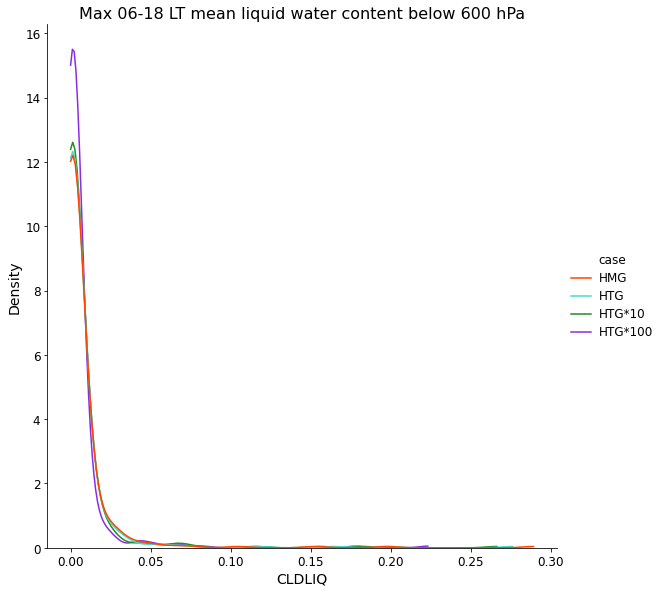

In [42]:
# Define dataframe
distVar = 'CLDLIQ'

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HMG').CLDLIQ.values * (1e3)),    'case': 'HMG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*01').CLDLIQ.values * (1e3)), 'case': 'HTG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*10').CLDLIQ.values * (1e3)), 'case': 'HTG*10'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*100').CLDLIQ.values * (1e3)),'case': 'HTG*100'}),
])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','turquoise','forestgreen','blueviolet'])


g.ax.set_title("Max 06-18 LT mean liquid water content below 600 hPa", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)


**Get full DS on those days in each category**

In [5]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDatesDS):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDatesDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDatesDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDatesDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [24]:
## What's happening on clear days in particular? 

day2_clearDays = getTimes_basedOnDates(day2_upsample, 
                                       day2_maxVals.isel(year_month_day=iClear).sel(case='HMG'))

# Did that work?
# len(np.unique(day2_clearDays.year_month_day.values)) # =217

# Get mean diurnal cycle arrays
day2clear_hrMeans = day2_clearDays.groupby("time.hour").mean(dim="time")
day2clear_hrStd   = day2_clearDays.groupby("time.hour").std(dim="time")

# Get number of obs going into each bin above (for std err) 
nTimes_means = np.full([24], np.nan)
for iHr in range(24): 
    nTimes_means[iHr]    = len(np.where(day2_clearDays["time.hour"]==iHr)[0])
    
day2clear_hrMeans['SampleCount'] = (('hour'), nTimes_means)



Text(0.5, 0, 'Local Hour')

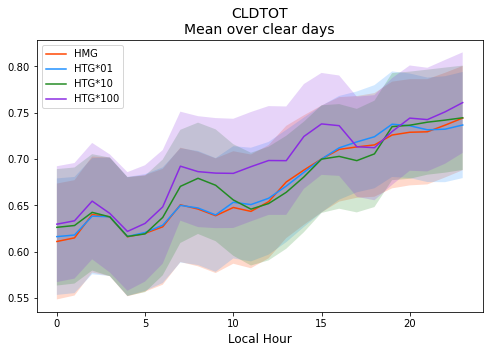

In [30]:
varSelPlot = 'CLDTOT' 
levSel     = None

fig,axs = plt.subplots(1,1, figsize=(8,5))

CIlevel = 1.645   ## 90% CI
    
colorList=['orangered','dodgerblue','forestgreen','blueviolet']

for iCase in range(len(day2clear_hrMeans.case.values)): 
    caseName = day2clear_hrMeans.case.values[iCase]
    axs.plot(np.arange(24), np.squeeze(day2clear_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

    axs.fill_between(np.arange(24), 
                     np.squeeze(day2clear_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2clear_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2clear_hrMeans['SampleCount'].values),
                     np.squeeze(day2clear_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2clear_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2clear_hrMeans['SampleCount'].values),
                     alpha = 0.2, facecolor=colorList[iCase])

axs.legend()
axs.set_title(varSelPlot+'\nMean over clear days', fontsize=14)
axs.set_xlabel('Local Hour', fontsize=12)


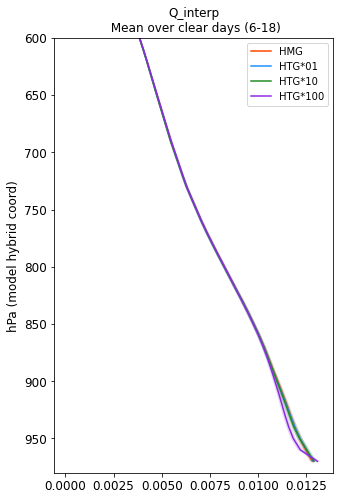

In [26]:
plotVar   = 'Q_interp' 
levString = 'levInterp' 


## Step 1: Which hours to average over? 
startHr = 6
endHr   = 18

iHours = np.where( (day2_clearDays['time.hour'].values>=startHr) & (day2_clearDays['time.hour'].values<=endHr) )[0]

## Step 2: Get a mean over all days during those hours only 
day2_meanProfiles = day2_clearDays.isel(time=iHours).mean(dim='time')
day2_stdProfiles  = day2_clearDays.isel(time=iHours).std(dim='time')


## Step 3: Plot 

fig,axs = plt.subplots(1,1, figsize=(5,8))
CIlevel = 1.645   ## 90% CI
colorList=['orangered','dodgerblue','forestgreen','blueviolet']


for iCase in range(len(day2_meanProfiles.case.values)): 
    caseName = day2_meanProfiles.case.values[iCase]
    
    valuesCase = np.squeeze(day2_meanProfiles.sel(case=caseName)[plotVar].values)

    axs.plot(valuesCase, day2_meanProfiles[levString].values,
             color=colorList[iCase],label=caseName)
    axs.fill_betweenx(day2_meanProfiles[levString].values, 
                      valuesCase-CIlevel*(np.squeeze(day2_stdProfiles.sel(case=caseName)[plotVar].values)/np.sqrt(len(iHours))),
                      valuesCase+CIlevel*(np.squeeze(day2_stdProfiles.sel(case=caseName)[plotVar].values)/np.sqrt(len(iHours))),
                      alpha = 0.2, facecolor=colorList[iCase])


axs.legend()
axs.invert_yaxis()
axs.set_ylim([980,600])
axs.set_title(plotVar+'\n Mean over clear days ('+str(startHr)+'-'+str(endHr)+')')

if varSelPlot.endswith('_interp'):
    axs.set_ylabel('hPa', fontsize=12)
else:
    axs.set_ylabel('hPa (model hybrid coord)', fontsize=12)

axs.tick_params(axis='both', labelsize= 12)

# axs.set_xlim([285,305])


## Maybe a slightly different definition of clear/cloudy days 

In [25]:
# Select only the hours 06-18 LT
iHours        = np.where( (day2_upsample['time.hour']>=6) & (day2_upsample['time.hour']<=18) )[0]
day2_hourSel  = day2_upsample['TGCLDLWP'].isel(time=iHours)

# For each date, get the max value in daytime TGCLDLWC  
day2_maxVals   = day2_hourSel.groupby('year_month_day').max(dim='time')

## Get list of dates in string form
strDates = []
for iDate in range(len(day2_maxVals.year_month_day.values)):
    yr_sel  = day2_maxVals.year_month_day_level_0[iDate]
    mon_sel = day2_maxVals.year_month_day_level_1[iDate]
    day_sel = day2_maxVals.year_month_day_level_2[iDate]

    strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))

## Now get the dates falling within certain percentages 
lowPct  = 20
highPct = 80

print('Using HMG:')
print('- - - - - - - - ')
print(lowPct,'th percentile difference (HMG):  %.3e'  % np.nanpercentile(day2_maxVals.sel(case='HMG'), lowPct))
print()
iLow_HMG   = np.where(day2_maxVals.sel(case='HMG')   <= np.nanpercentile(day2_maxVals.sel(case='HMG'), lowPct))[0]

## Get indices of dates that are consistent...
listLow_HMG  = list(set( iLow_HMG ) )



Using HMG:
- - - - - - - - 
20 th percentile difference (HMG):  1.255e-02



[None, None, None, None, None, None, None, None]

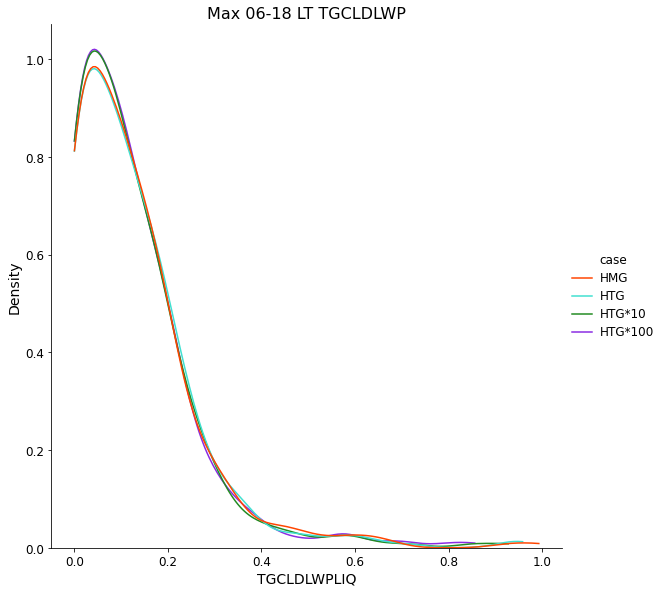

In [32]:
# Define dataframe
distVar = 'TGCLDLWPLIQ'

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HMG').values ),    'case': 'HMG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*01').values ), 'case': 'HTG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*10').values ), 'case': 'HTG*10'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*100').values),'case': 'HTG*100'}),
])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','turquoise','forestgreen','blueviolet'])


g.ax.set_title("Max 06-18 LT TGCLDLWP", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)


In [26]:

## What's happening on clear days in particular? 
day2_clearDays = getTimes_basedOnDates(day2_upsample, 
                        day2_maxVals.sel(case='HMG').isel(year_month_day=listLow_HMG))

# Get mean diurnal cycle arrays
day2clear_hrMeans = day2_clearDays.groupby("time.hour").mean(dim="time")
day2clear_hrStd   = day2_clearDays.groupby("time.hour").std(dim="time")

# Get number of obs going into each bin above (for std err) 
nTimes_means = np.full([24], np.nan)
for iHr in range(24): 
    nTimes_means[iHr]    = len(np.where(day2_clearDays["time.hour"]==iHr)[0])
    
day2clear_hrMeans['SampleCount'] = (('hour'), nTimes_means)




NameError: name 'getTimes_basedOnDates' is not defined

Text(0.5, 0, 'Local Hour')

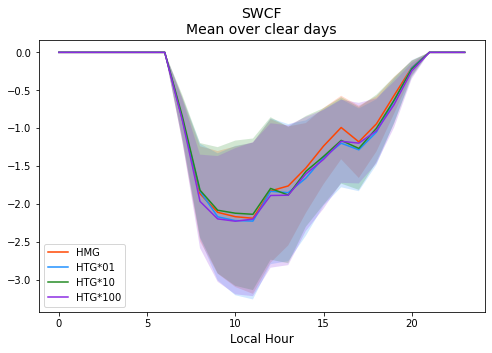

In [66]:
varSelPlot = 'SWCF' 
levSel     = None

fig,axs = plt.subplots(1,1, figsize=(8,5))

CIlevel = 1.645   ## 90% CI
    
colorList=['orangered','dodgerblue','forestgreen','blueviolet']

for iCase in range(len(day2clear_hrMeans.case.values)): 
    caseName = day2clear_hrMeans.case.values[iCase]
    axs.plot(np.arange(24), np.squeeze(day2clear_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

    axs.fill_between(np.arange(24), 
                     np.squeeze(day2clear_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2clear_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2clear_hrMeans['SampleCount'].values),
                     np.squeeze(day2clear_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2clear_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2clear_hrMeans['SampleCount'].values),
                     alpha = 0.2, facecolor=colorList[iCase])

axs.legend()
axs.set_title(varSelPlot+'\nMean over clear days', fontsize=14)
axs.set_xlabel('Local Hour', fontsize=12)


In [17]:
# Select only the hours 06-18 LT
iHours        = np.where( (day2_upsampleCLM['time.hour']>=6) & (day2_upsample['time.hour']<=18) )[0]
day2_hourSel  = day2_upsampleCLM['SOILWATER_10CM'].isel(time=iHours)

# For each date, get the mean value of daytime 10cm soil water  
day2_maxVals   = day2_hourSel.groupby('year_month_day').mean(dim='time')

## Get list of dates in string form
strDates = []
for iDate in range(len(day2_maxVals.year_month_day.values)):
    yr_sel  = day2_maxVals.year_month_day_level_0[iDate]
    mon_sel = day2_maxVals.year_month_day_level_1[iDate]
    day_sel = day2_maxVals.year_month_day_level_2[iDate]

    strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))

## Now get the dates falling within certain percentages 
lowPct  = 20
highPct = 80

print('Using HMG:')
print('- - - - - - - - ')
print(lowPct,'th percentile difference (HMG):  %.3e'  % np.nanpercentile(day2_maxVals.sel(case='HMG'), lowPct))
print(highPct,'th percentile difference (HMG):  %.3e'  % np.nanpercentile(day2_maxVals.sel(case='HMG'), highPct))
print()
iLow_HMG   = np.where(day2_maxVals.sel(case='HMG')   <= np.nanpercentile(day2_maxVals.sel(case='HMG'), lowPct))[0]
iHigh_HMG  = np.where(day2_maxVals.sel(case='HMG')   <= np.nanpercentile(day2_maxVals.sel(case='HMG'), highPct))[0]

## Get indices of dates that are consistent...
listLow_HMG  = list(set( iLow_HMG ) )
listHigh_HMG = list(set( iHigh_HMG) )



Using HMG:
- - - - - - - - 
20 th percentile difference (HMG):  1.850e+01
80 th percentile difference (HMG):  2.887e+01



[None, None, None, None, None, None, None, None]

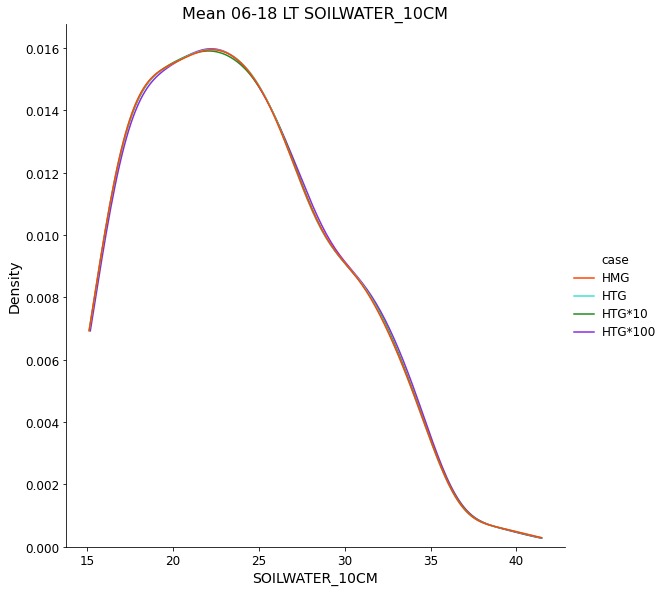

In [18]:
# Define dataframe
distVar = 'SOILWATER_10CM'

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HMG').values ),    'case': 'HMG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*01').values ), 'case': 'HTG'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*10').values ), 'case': 'HTG*10'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(day2_maxVals.sel(case='HTG*100').values),'case': 'HTG*100'}),
])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','turquoise','forestgreen','blueviolet'])


g.ax.set_title("Mean 06-18 LT SOILWATER_10CM", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)


In [51]:
## What's happening on different days in particular? 
day2_dryDays = getTimes_basedOnDates(day2_upsample, 
                                     day2_maxVals.sel(case='HMG').isel(year_month_day=listLow_HMG))

day2clm_dryDays = getTimes_basedOnDates(day2_upsampleCLM, 
                                        day2_maxVals.sel(case='HMG').isel(year_month_day=listLow_HMG))

# Get mean diurnal cycle arrays
day2dry_hrMeans = day2_dryDays.groupby("time.hour").mean(dim="time")
day2dry_hrStd   = day2_dryDays.groupby("time.hour").std(dim="time")

# Get number of obs going into each bin above (for std err) 
nTimes_means = np.full([24], np.nan)
for iHr in range(24): 
    nTimes_means[iHr]    = len(np.where(day2_dryDays["time.hour"]==iHr)[0])
    
day2dry_hrMeans['SampleCount'] = (('hour'), nTimes_means)

# Get mean diurnal cycle arrays
day2dryCLM_hrMeans = day2clm_dryDays.groupby("time.hour").mean(dim="time")
day2dryCLM_hrStd   = day2clm_dryDays.groupby("time.hour").std(dim="time")


In [52]:
## What's happening on different days in particular? 
day2_wetDays = getTimes_basedOnDates(day2_upsample, 
                                     day2_maxVals.sel(case='HMG').isel(year_month_day=listHigh_HMG))

day2clm_wetDays = getTimes_basedOnDates(day2_upsampleCLM, 
                                        day2_maxVals.sel(case='HMG').isel(year_month_day=listHigh_HMG))

# Get mean diurnal cycle arrays
day2wet_hrMeans = day2_wetDays.groupby("time.hour").mean(dim="time")
day2wet_hrStd   = day2_wetDays.groupby("time.hour").std(dim="time")

# Get number of obs going into each bin above (for std err) 
nTimes_means = np.full([24], np.nan)
for iHr in range(24): 
    nTimes_means[iHr]    = len(np.where(day2_wetDays["time.hour"]==iHr)[0])
    
day2wet_hrMeans['SampleCount'] = (('hour'), nTimes_means)

# Get mean diurnal cycle arrays
day2wetCLM_hrMeans = day2clm_wetDays.groupby("time.hour").mean(dim="time")
day2wetCLM_hrStd   = day2clm_wetDays.groupby("time.hour").std(dim="time")


Text(0.5, 0, 'Local Hour')

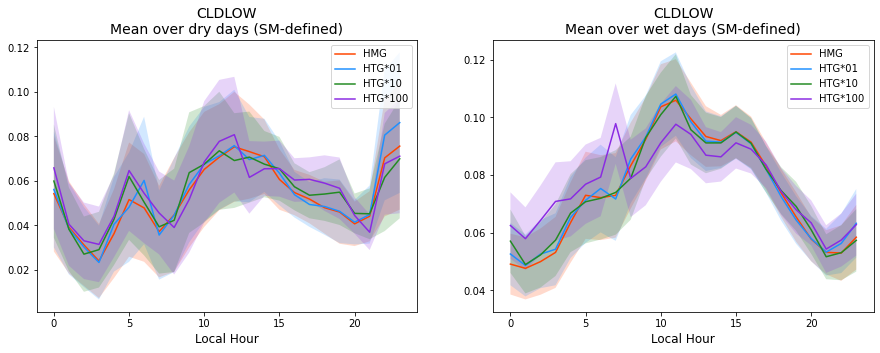

In [35]:
varSelPlot = 'CLDLOW' 
levSel     = None

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

CIlevel = 1.645   ## 90% CI
    
colorList=['orangered','dodgerblue','forestgreen','blueviolet']

for iCase in range(len(day2dry_hrMeans.case.values)): 
    caseName = day2dry_hrMeans.case.values[iCase]
    
    axs[0].plot(np.arange(24), np.squeeze(day2dry_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

    axs[0].fill_between(np.arange(24), 
                     np.squeeze(day2dry_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2dry_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2dry_hrMeans['SampleCount'].values),
                     np.squeeze(day2dry_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2dry_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2dry_hrMeans['SampleCount'].values),
                     alpha = 0.2, facecolor=colorList[iCase])

    
    axs[1].plot(np.arange(24), np.squeeze(day2wet_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

    axs[1].fill_between(np.arange(24), 
                     np.squeeze(day2wet_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2wet_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2wet_hrMeans['SampleCount'].values),
                     np.squeeze(day2wet_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2wet_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2wet_hrMeans['SampleCount'].values),
                     alpha = 0.2, facecolor=colorList[iCase])
    
    
axs[0].legend()
axs[0].set_title(varSelPlot+'\nMean over dry days (SM-defined)', fontsize=14)
axs[0].set_xlabel('Local Hour', fontsize=12)

axs[1].legend()
axs[1].set_title(varSelPlot+'\nMean over wet days (SM-defined)', fontsize=14)
axs[1].set_xlabel('Local Hour', fontsize=12)


(16.5, 22.4)

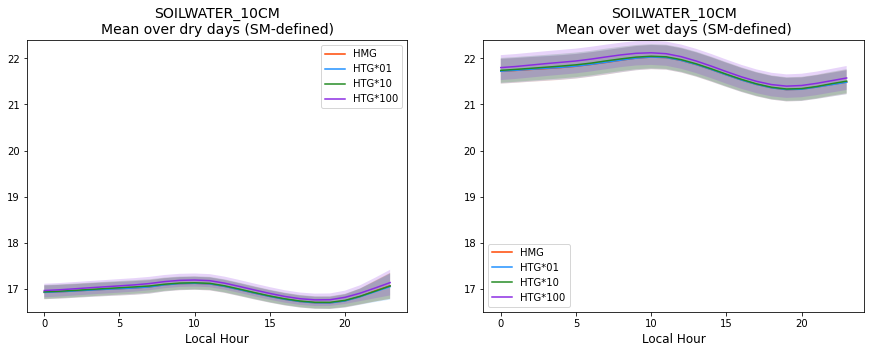

In [57]:
varSelPlot = 'SOILWATER_10CM' 
levSel     = None

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

CIlevel = 1.645   ## 90% CI
    
colorList=['orangered','dodgerblue','forestgreen','blueviolet']

for iCase in range(len(day2dryCLM_hrMeans.case.values)): 
    caseName = day2dryCLM_hrMeans.case.values[iCase]
    
    axs[0].plot(np.arange(24), np.squeeze(day2dryCLM_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

    axs[0].fill_between(np.arange(24), 
                     np.squeeze(day2dryCLM_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2dryCLM_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2dry_hrMeans['SampleCount'].values),
                     np.squeeze(day2dryCLM_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2dryCLM_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2dry_hrMeans['SampleCount'].values),
                     alpha = 0.2, facecolor=colorList[iCase])

    
    axs[1].plot(np.arange(24), np.squeeze(day2wetCLM_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel]),color=colorList[iCase],label=caseName)

    axs[1].fill_between(np.arange(24), 
                     np.squeeze(day2wetCLM_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])-CIlevel*np.squeeze(day2wetCLM_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2wet_hrMeans['SampleCount'].values),
                     np.squeeze(day2wetCLM_hrMeans.isel(case=iCase)[varSelPlot].values[:,levSel])+CIlevel*np.squeeze(day2wetCLM_hrStd.isel(case=iCase)[varSelPlot].values[:,levSel])/np.sqrt(day2wet_hrMeans['SampleCount'].values),
                     alpha = 0.2, facecolor=colorList[iCase])
    
    
axs[0].legend()
axs[0].set_title(varSelPlot+'\nMean over dry days (SM-defined)', fontsize=14)
axs[0].set_xlabel('Local Hour', fontsize=12)

axs[1].legend()
axs[1].set_title(varSelPlot+'\nMean over wet days (SM-defined)', fontsize=14)
axs[1].set_xlabel('Local Hour', fontsize=12)

axs[0].set_ylim([16.5,22.4])
axs[1].set_ylim([16.5,22.4])


Text(0.5, 1.0, '\nHTG*100-HMG (wet days)')

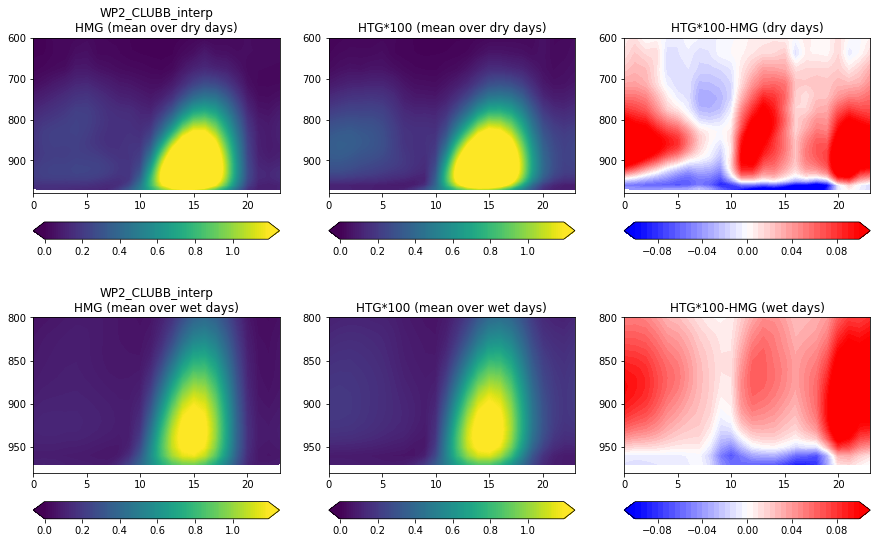

In [48]:
# plotVar   = 'Q_interp' 
# levsRaw   = np.arange(0,0.015, 0.0005)
# levsDiff  = np.arange(-0.0015, 0.0016, 0.0001)

# plotVar   = 'T_interp' 
# levsRaw   = np.arange(275,305,1)
# levsDiff  = np.arange(-1.3, 1.31, 0.01)

# plotVar   = 'CLOUD_interp' 
# levsRaw   = np.arange(0,0.1,0.001)
# levsDiff  = np.arange(-0.02,0.021, 0.001)

# plotVar   = 'THLP2_CLUBB_interp' 
# levsRaw   = np.arange(0.01,1.5,0.005)
# levsDiff  = np.arange(-1.0, 1.01, 0.01)

# plotVar   = 'RTP2_CLUBB_interp' 
# levsRaw   = np.arange(0.02,0.6,0.005)
# levsDiff  = np.arange(-0.8,0.81, 0.01)

# plotVar   = 'RTPTHLP_CLUBB_interp' 
# levsRaw   = np.arange(-0.25,0.05,0.005)
# levsDiff  = np.arange(-0.3,0.31, 0.01)

plotVar   = 'WP2_CLUBB_interp' 
levsRaw   = np.arange(0.0, 1.2, 0.01)
levsDiff  = np.arange(-0.1,0.105, 0.005)

levString = 'levInterp' 

## Select which multiplier to plot 
caseSel          = 'HTG*100'
day2dry_hrMeans_HTG = np.squeeze(day2dry_hrMeans.sel(case=caseSel)[plotVar].values)
day2wet_hrMeans_HTG = np.squeeze(day2wet_hrMeans.sel(case=caseSel)[plotVar].values)

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
## Dry days
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## Make Plot 
fig,axs = plt.subplots(2,3, figsize=(15,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.8)

c0 = axs[0].contourf(np.arange(24), day2dry_hrMeans[levString].values, 
                     np.squeeze(day2dry_hrMeans.sel(case='HMG')[plotVar].values).transpose(), 
                     levsRaw, 
                     cmap='viridis', extend='both')
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(c0, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()

c1 = axs[1].contourf(np.arange(24), day2dry_hrMeans[levString].values, 
                     day2dry_hrMeans_HTG.transpose(), 
                     levsRaw, 
                     cmap='viridis', extend='both')
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(c1, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()

c2 = axs[2].contourf(np.arange(24), day2dry_hrMeans[levString].values, 
                    (day2dry_hrMeans_HTG - np.squeeze(day2dry_hrMeans.sel(case='HMG')[plotVar].values)).transpose(), 
                    levsDiff, 
                    cmap='bwr', extend='both')
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(c2, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()


axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_ylim([980, 600])
axs[1].set_ylim([980, 600])
axs[2].set_ylim([980, 600])

axs[0].set_title(plotVar+'\nHMG (mean over dry days)')
axs[1].set_title('\n'+caseSel+' (mean over dry days)')
axs[2].set_title('\n'+caseSel+'-HMG (dry days)')



## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
## Wet days
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
c0 = axs[3].contourf(np.arange(24), day2wet_hrMeans[levString].values, 
                     np.squeeze(day2wet_hrMeans.sel(case='HMG')[plotVar].values).transpose(), 
                     levsRaw, 
                     cmap='viridis', extend='both')
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(c0, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()

c1 = axs[4].contourf(np.arange(24), day2wet_hrMeans[levString].values, 
                     day2wet_hrMeans_HTG.transpose(), 
                     levsRaw, 
                     cmap='viridis', extend='both')
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(c1, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()

c2 = axs[5].contourf(np.arange(24), day2wet_hrMeans[levString].values, 
                    (day2wet_hrMeans_HTG - np.squeeze(day2wet_hrMeans.sel(case='HMG')[plotVar].values)).transpose(), 
                    levsDiff, 
                    cmap='bwr', extend='both')
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(c2, orientation='horizontal',cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()


axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[3].set_ylim([980, 800])
axs[4].set_ylim([980, 800])
axs[5].set_ylim([980, 800])

axs[3].set_title(plotVar+'\nHMG (mean over wet days)')
axs[4].set_title('\n'+caseSel+' (mean over wet days)')
axs[5].set_title('\n'+caseSel+'-HMG (wet days)')

